# Video Fake News Detection Model

**Procedure:** 

- Extract frames from videos
- Use Vision Transformer (ViT) to extract visual features from each frame.
- Pass the features into an LSTM model to classify the entire video as either Fake or Real.
- Automatically train the model from scratch
- Evaluate the model using accuracy, precision, recall, F1-score, and speed (time per video)

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import os
import time
from sklearn.metrics import classification_report
from transformers import ViTModel, ViTFeatureExtractor
import numpy as np
import torch.optim as optim
import time
from tqdm import tqdm


2025-03-15 21:42:46.044634: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Preprocessing Transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Frame Extraction
def extract_frames(video_path, frame_rate=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps // frame_rate)
    count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_tensor = transform(frame_rgb)
            frames.append(frame_tensor)
        count += 1
    
    cap.release()
    return torch.stack(frames) if len(frames) > 0 else None

# ViT Feature Extractor
class ViTFeatureExtractorModel(nn.Module):
    def __init__(self):
        super(ViTFeatureExtractorModel, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        
    def forward(self, x):
        with torch.no_grad():
            outputs = self.vit(pixel_values=x).last_hidden_state[:, 0, :]
        return outputs

# LSTM Classifier
class VideoFakeNewsDetector(nn.Module):
    def __init__(self, input_size=768, hidden_size=128, num_layers=2, num_classes=2):
        super(VideoFakeNewsDetector, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])



Device: cpu


## Test Prediction - Unseen Data

Using device: cpu
Loading model from best_video_model.pth
Model loaded (Best accuracy: 100.00%, Epoch: 2)
Processing video: test/video1ff.mp4


/tmp/ipykernel_2468/647968574.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Loaded 32 frames from video


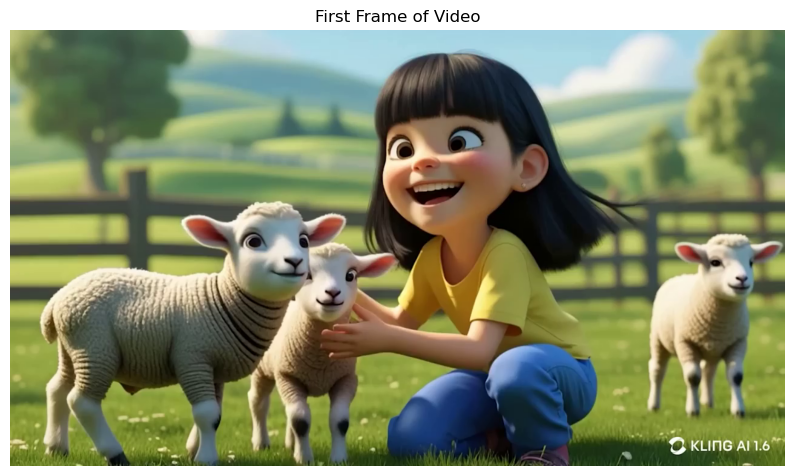


=== Prediction Results ===
Prediction: Real
Confidence: 0.5035
Processing Time: 17.26 seconds

Class Probabilities:
Fake: 0.4965
Real: 0.5035


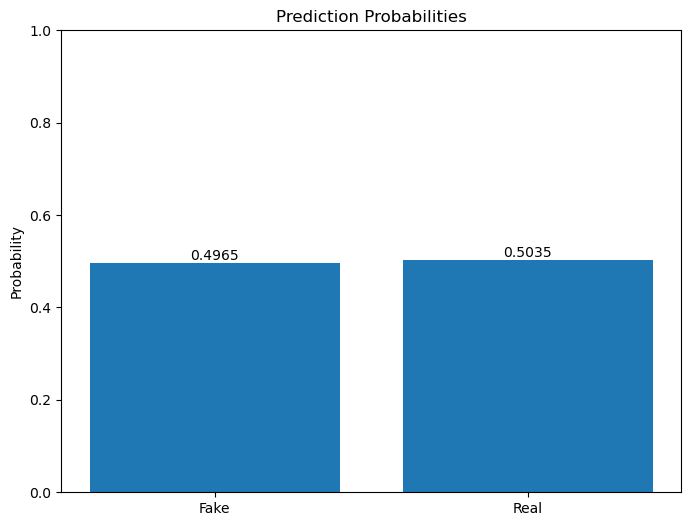


Results saved to prediction_results_20250315_214352.txt


In [ ]:
import torch
import cv2
import numpy as np
from pathlib import Path
import time
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


def load_best_model(model_path, model, optimizer=None):
    """
    Load the best saved model with proper device mapping
    """
    print(f"Loading model from {model_path}")
    # Add map_location parameter to handle CPU/GPU differences
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(model_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded (Best accuracy: {checkpoint['accuracy']:.2f}%, Epoch: {checkpoint['epoch']})")
    return model
    

def predict_video(video_path, model, vit_extractor, device, display_frames=True):
    """
    Make prediction on a single video with visualization
    """
    model.eval()
    start_time = time.time()
    
    try:
        # Load and process video frames
        print(f"Processing video: {video_path}")
        frames = load_video_frames(video_path)
        
        if display_frames:
            # Display first frame
            plt.figure(figsize=(10, 6))
            plt.imshow(frames[0].permute(1, 2, 0))
            plt.title("First Frame of Video")
            plt.axis('off')
            plt.show()
        
        # Process frames
        processed_frames = torch.stack([transform(frame) for frame in frames])
        processed_frames = processed_frames.to(device)
        
        # Make prediction
        with torch.no_grad():
            features = vit_extractor(processed_frames)
            outputs = model(features)
            
            if outputs.dim() == 1:
                outputs = outputs.unsqueeze(0)
            
            # Get probabilities
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            # Get class probabilities
            class_probs = probabilities[0].cpu().numpy()
            
        # Calculate processing time
        processing_time = time.time() - start_time
        
        # Prepare results
        result = {
            'prediction': 'Real' if predicted.item() == 1 else 'Fake',
            'confidence': confidence.item(),
            'processing_time': processing_time,
            'class_probabilities': {
                'Fake': class_probs[0],
                'Real': class_probs[1]
            }
        }
        
        # Print results
        print("\n=== Prediction Results ===")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print(f"Processing Time: {result['processing_time']:.2f} seconds")
        print("\nClass Probabilities:")
        print(f"Fake: {result['class_probabilities']['Fake']:.4f}")
        print(f"Real: {result['class_probabilities']['Real']:.4f}")
        
        # Visualize probabilities
        plt.figure(figsize=(8, 6))
        plt.bar(['Fake', 'Real'], [class_probs[0], class_probs[1]])
        plt.title('Prediction Probabilities')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        
        # Add probability values on top of bars
        for i, prob in enumerate([class_probs[0], class_probs[1]]):
            plt.text(i, prob, f'{prob:.4f}', ha='center', va='bottom')
            
        plt.show()
        
        return result
        
    except Exception as e:
        print(f"Error processing video: {str(e)}")
        return None

def load_video_frames(video_path, max_frames=32):
    """
    Load frames from a video file
    """
    if not Path(video_path).exists():
        raise FileNotFoundError(f"Video file not found: {video_path}")
        
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    
    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to tensor and normalize
        frame = torch.FloatTensor(frame).permute(2, 0, 1) / 255.0
        frames.append(frame)
        frame_count += 1
    
    cap.release()
    
    if len(frames) == 0:
        raise ValueError(f"No frames could be loaded from {video_path}")
        
    frames = torch.stack(frames)
    print(f"Loaded {len(frames)} frames from video")
    return frames

# Example usage
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    try:
        # Initialize model and load weights
        video_model = VideoFakeNewsDetector().to(device)
        vit_extractor = ViTFeatureExtractorModel().to(device)
        
        # Load the best model
        model_path = 'best_video_model.pth'
        video_model = load_best_model(model_path, video_model)
        video_model.eval()
        
        # Define preprocessing transform
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Test on a video
        video_path = "test/video1ff.mp4"  # fake video
        
        # Make prediction
        result = predict_video(
            video_path=video_path,
            model=video_model,
            vit_extractor=vit_extractor,
            device=device,
            display_frames=True  # Set to False to hide frame display
        )
        
        if result:
            # You can access the results
            prediction = result['prediction']
            confidence = result['confidence']
            processing_time = result['processing_time']
            probabilities = result['class_probabilities']
            
            # Save results to file
            from datetime import datetime
            
            results_file = f"prediction_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
            with open(results_file, 'w') as f:
                f.write("=== Video Prediction Results ===\n")
                f.write(f"Video: {video_path}\n")
                f.write(f"Prediction: {prediction}\n")
                f.write(f"Confidence: {confidence:.4f}\n")
                f.write(f"Processing Time: {processing_time:.2f} seconds\n")
                f.write("\nClass Probabilities:\n")
                f.write(f"Fake: {probabilities['Fake']:.4f}\n")
                f.write(f"Real: {probabilities['Real']:.4f}\n")
            
            print(f"\nResults saved to {results_file}")
            
    except Exception as e:
        print(f"Error: {str(e)}")

Processing video: test/video1rr.mp4
Loaded 32 frames from video


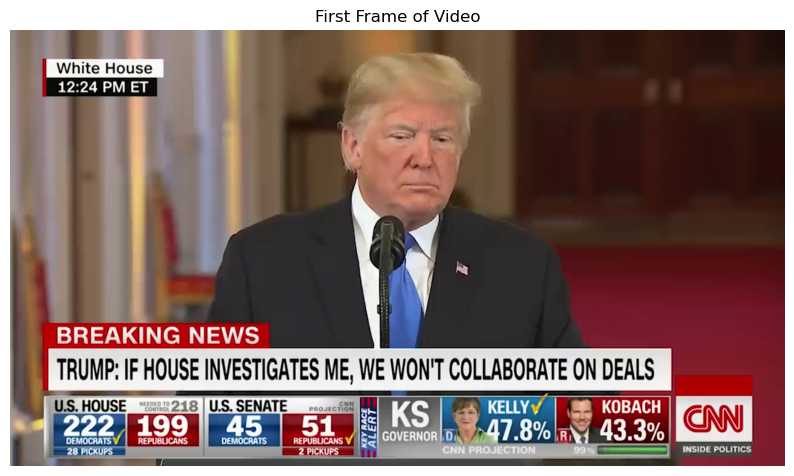


=== Prediction Results ===
Prediction: Real
Confidence: 0.5189
Processing Time: 18.99 seconds

Class Probabilities:
Fake: 0.4811
Real: 0.5189


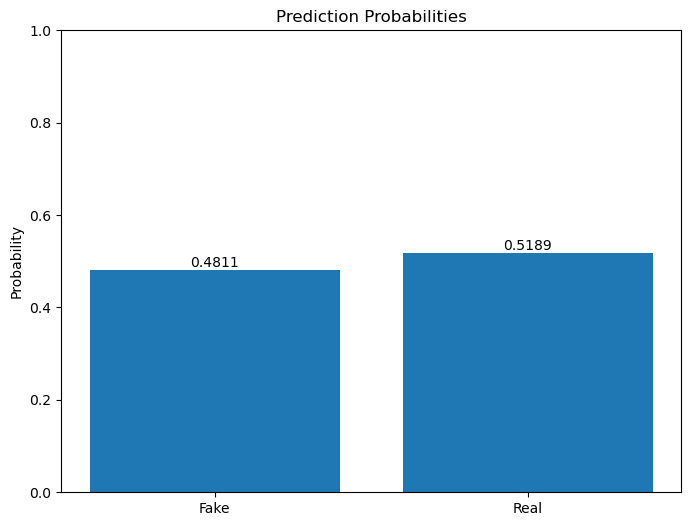

In [4]:
# For a single video - Real video
result = predict_video(
    video_path="test/video1rr.mp4",
    model=video_model,
    vit_extractor=vit_extractor,
    device=device
)



Processing video: test/video1ff.mp4
Loaded 32 frames from video


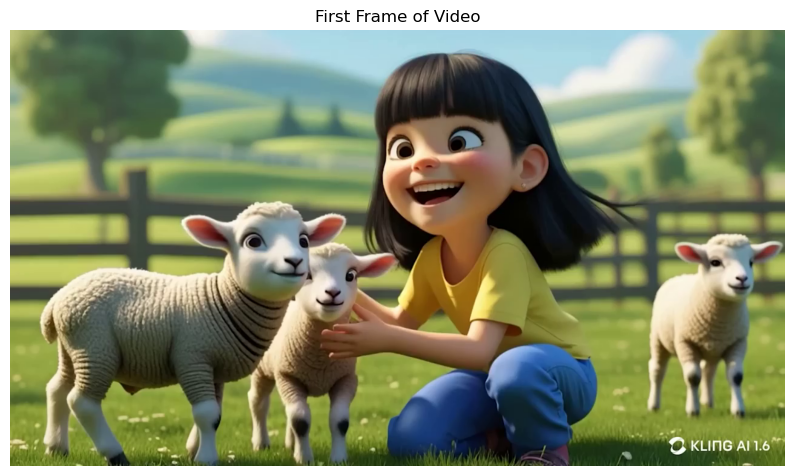


=== Prediction Results ===
Prediction: Real
Confidence: 0.5035
Processing Time: 16.74 seconds

Class Probabilities:
Fake: 0.4965
Real: 0.5035


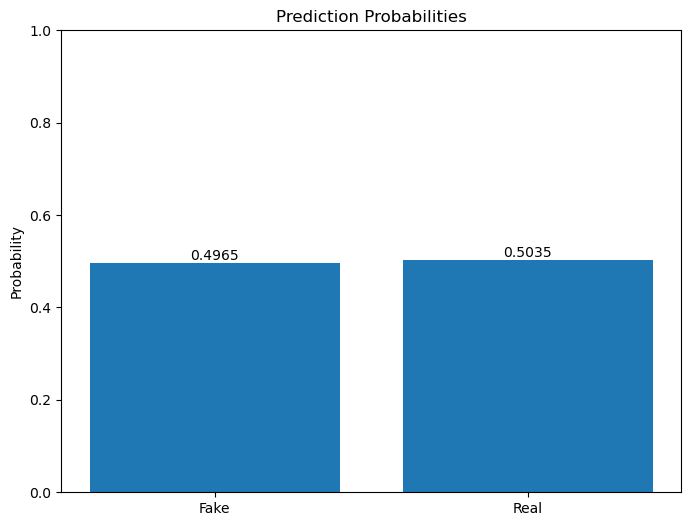

Processing video: test/video2ff.mp4
Loaded 32 frames from video


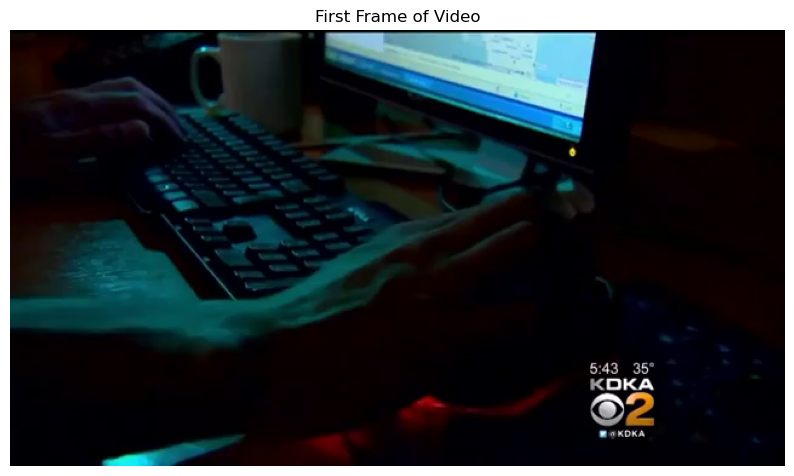


=== Prediction Results ===
Prediction: Real
Confidence: 0.5023
Processing Time: 15.60 seconds

Class Probabilities:
Fake: 0.4977
Real: 0.5023


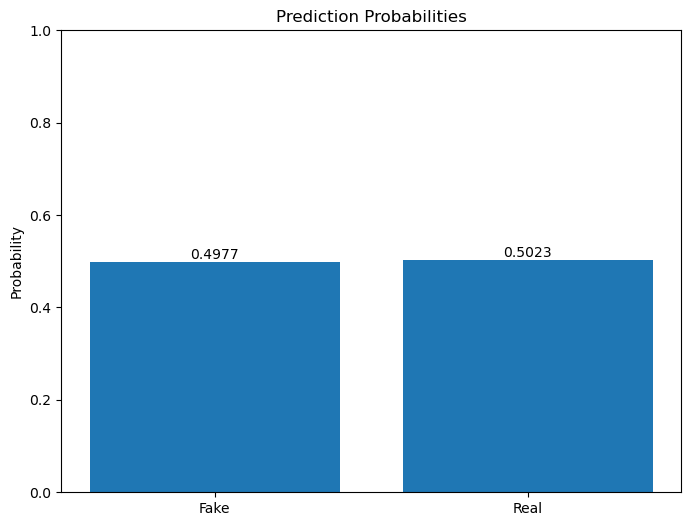

In [5]:
# Or process multiple videos - Fake videos
test_videos = ["test/video1ff.mp4", "test/video2ff.mp4"]
for video_path in test_videos:
    result = predict_video(
        video_path=video_path,
        model=video_model,
        vit_extractor=vit_extractor,
        device=device
    )